In [2]:
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load dataset
data = fetch_openml("adult", version=2, as_frame=True)
df = data.frame

# Drop missing values
df = df.replace("?", pd.NA).dropna()

# Encode categorical features
for col in df.select_dtypes(include="category").columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

X = df.drop("class", axis=1)
y = df["class"]
y = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


C:\Users\hziad\PycharmProjects\DataWranglingRESQ\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:46:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8715312327252626


 98%|===================| 8893/9045 [00:35<00:00]        

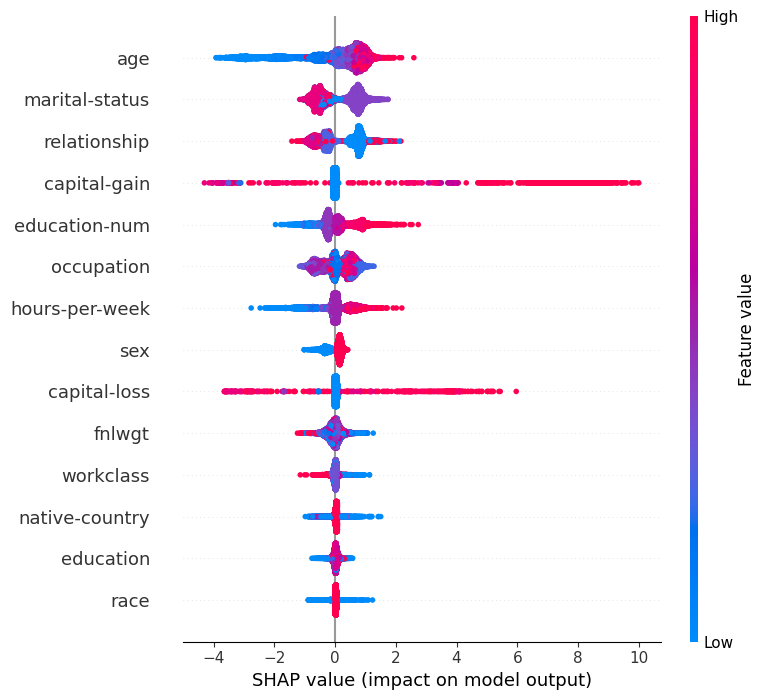

ValueError: visualize() can only display Explanation objects (or arrays of them)!

In [7]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

# Force plot for a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])


In [5]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['<=50K', '>50K'],
    mode='classification'
)

i = 3  # You can change this index to look at different examples
exp = explainer.explain_instance(X_test.values[i], model.predict_proba, num_features=10)

try:
    import display, HTML
    display(HTML(exp.as_html()))
except Exception as e:
    print("Notebook rendering failed, saving to HTML file instead.")
    with open("lime_explanation.html", "w", encoding="utf-8") as f:
        f.write(exp.as_html())
    print("Explanation saved to lime_explanation.html")



Notebook rendering failed, saving to HTML file instead.
Explanation saved to lime_explanation.html


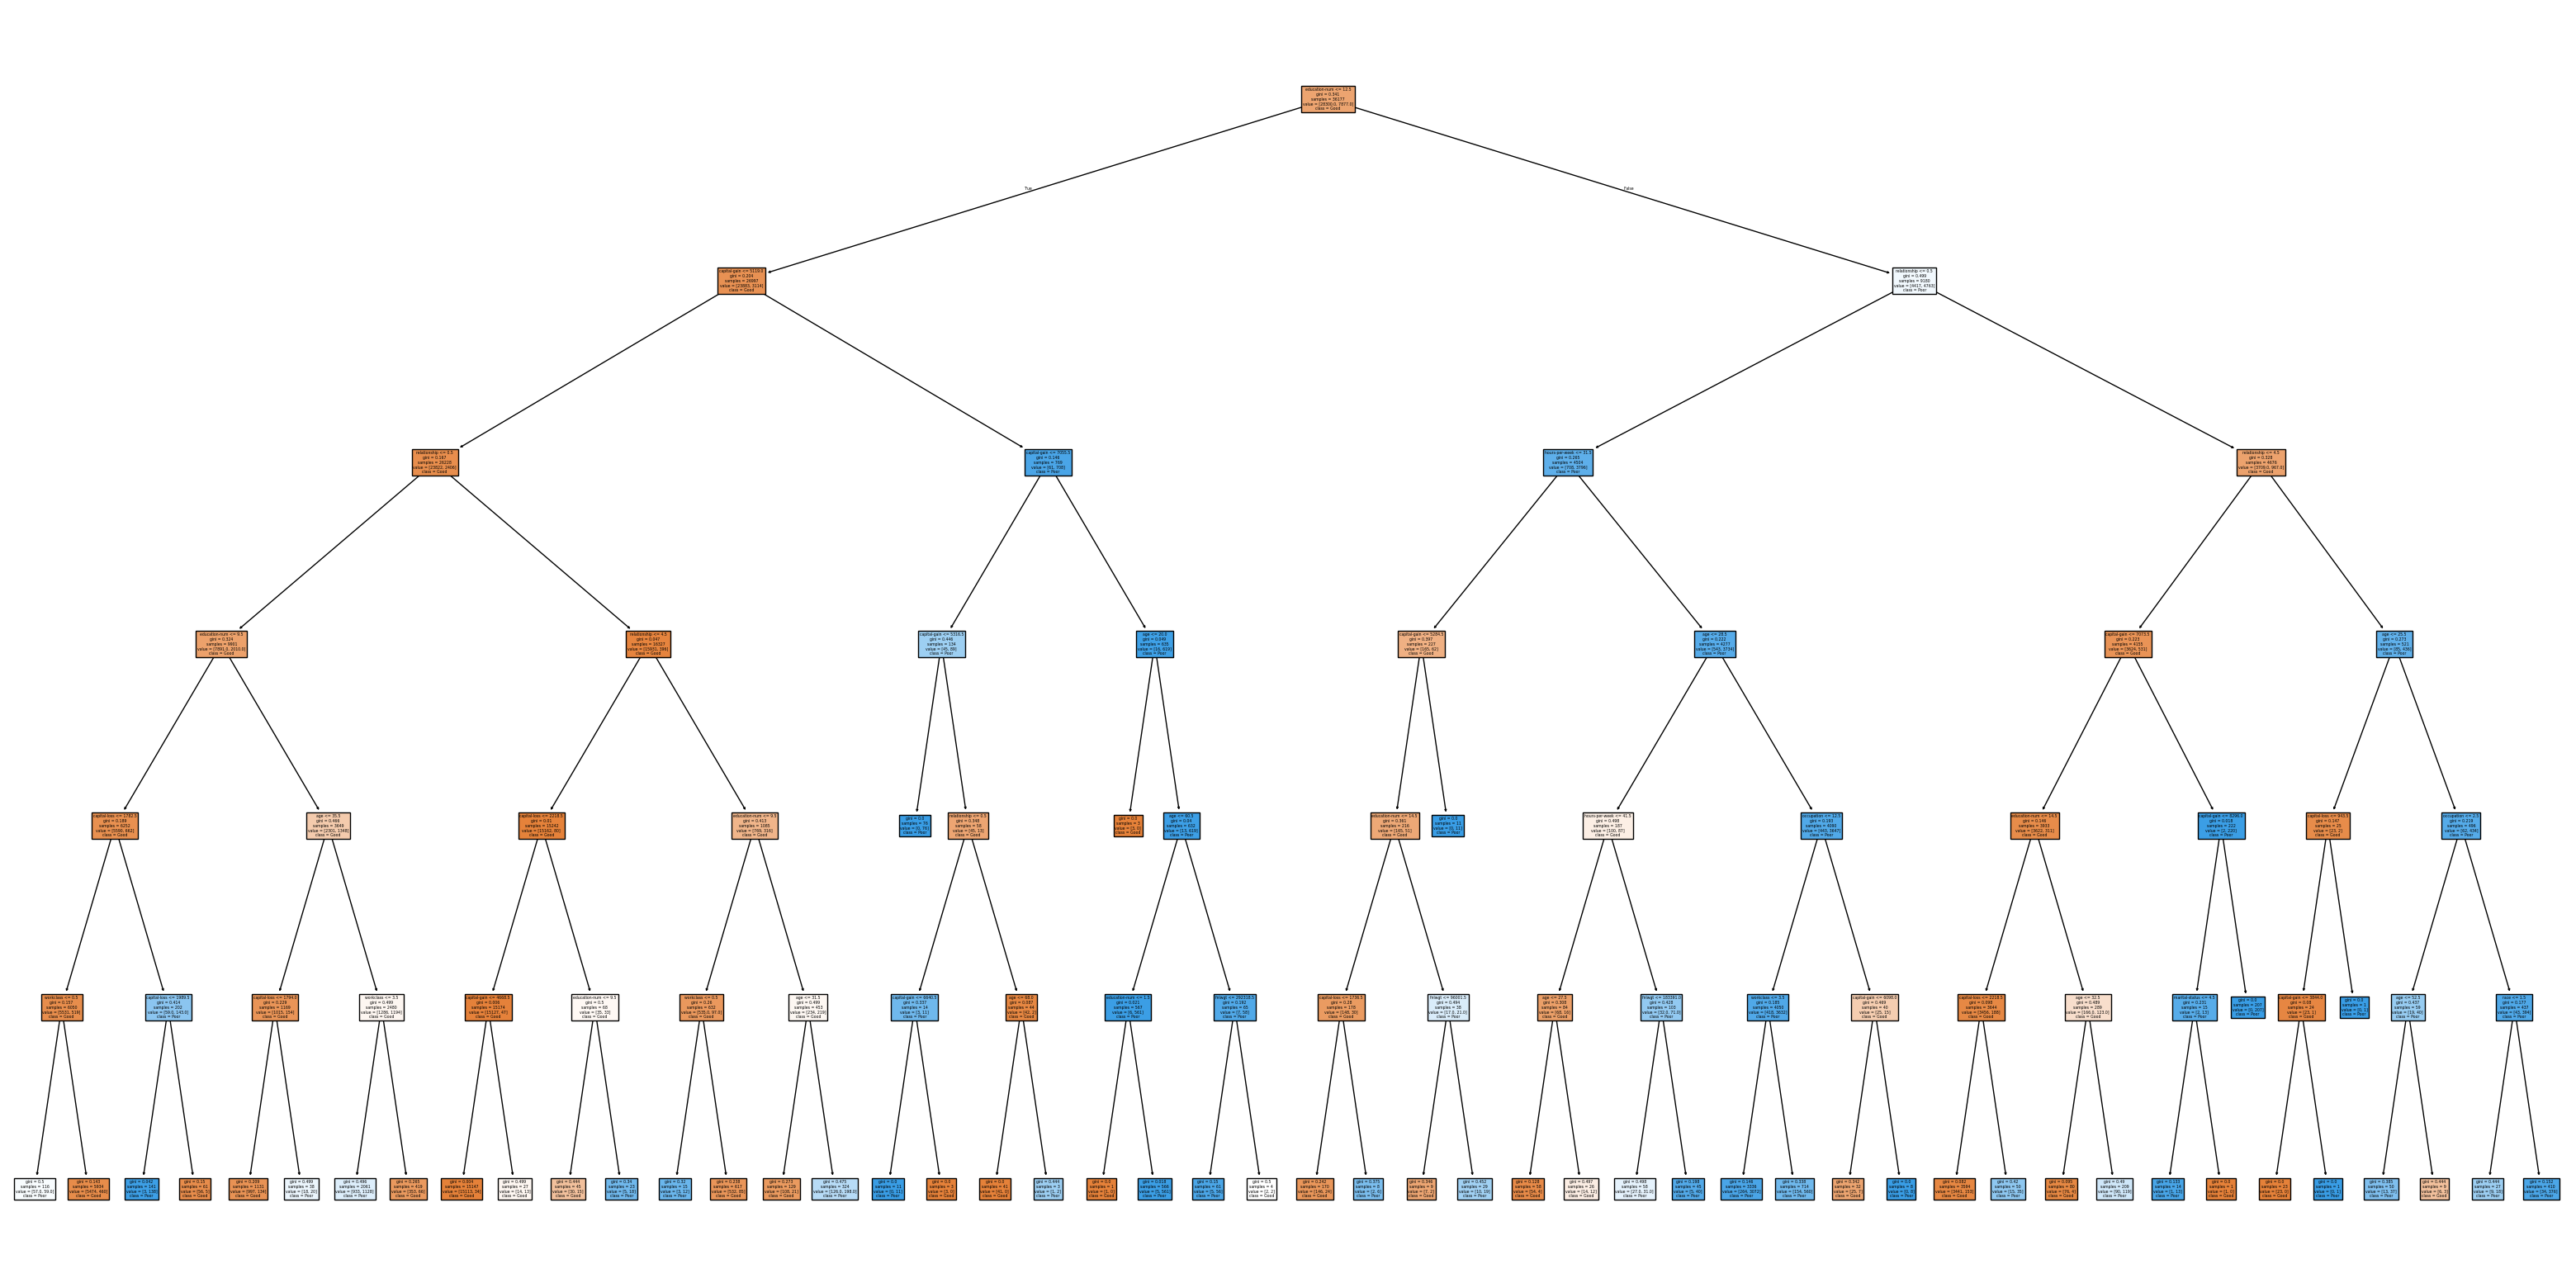

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

# Train a surrogate tree on X and XGBoost's predictions
y_pred_proba = model.predict_proba(X_train)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

surrogate = DecisionTreeClassifier(max_depth=6)
surrogate.fit(X_train, y_pred)

# Visualize
plt.figure(figsize=(40,20))
tree.plot_tree(surrogate, feature_names=X_train.columns, class_names=["Good", "Poor"], filled=True)
plt.show()



C:\Users\hziad\PycharmProjects\DataWranglingRESQ\.venv\Lib\site-packages\xgboost\plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 4000x2000 with 0 Axes>

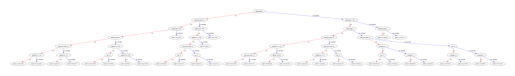

In [9]:
import matplotlib.pyplot as plt
from xgboost import plot_tree

plt.close('all')

plt.figure(figsize=(40, 20))
plot_tree(model, num_trees=0)

plt.savefig("tree.svg", format='svg', bbox_inches='tight')  # Save as SVG
plt.show()



In [10]:
import matplotlib.pyplot as plt

# Extract predictor names and weights
predictor_names = [f for f, w in explanation_data]
weights = [w for f, w in explanation_data]

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(predictor_names, weights, color=['green' if w > 0 else 'red' for w in weights])
ax.set_xlabel("Contribution to Prediction")
ax.set_title("LIME Explanation")

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.01 if width > 0 else width - 0.05,
            bar.get_y() + bar.get_height() / 2,
            f'{width:.3f}',
            va='center')

plt.tight_layout()
plt.show()





NameError: name 'explanation_data' is not defined